## Libraries Import

In [40]:
import math
import statistics as stat
import sklearn.metrics as sk
import pandas as pd
import numpy as np
import altair as alt
from altair import datum
import matplotlib.pyplot as plt
import seaborn as sns                     # for matrix scatter plots
from sklearn.impute import SimpleImputer  # basic imputation method
from sklearn.impute import KNNImputer     # k-nearest neighbour imputation method
from sklearn.experimental import enable_iterative_imputer # required for MICE imputation
from sklearn.impute import IterativeImputer # MICE imputation

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARMAResults 


## Data Import
- Rename columns
- Remove irrelavent columns
- Remove irrelavent rows
    - Production wells: leave only 'Producing' wells
    - Injection wells: leave only 'Injecting' wells
- Remove duplicates
- Remove nulls

- Group production and injection data by
    - Year
    - Month

In [2]:
inj_df = pd.read_excel('/Users/vanekang/Desktop/NSC/Data/UIC_InjectionData_All_Years.xlsx', sheet_name='UIC_Injection_Data')
prod_df = pd.read_excel('/Users/vanekang/Desktop/NSC/Data/Oil_Gas_Production_All_Years.xlsx', sheet_name = 'Production')

In [3]:
prod_df1 = prod_df[prod_df['Reported_Well_Status_A'] == 'Producing']
prod_df1 = prod_df[['Date_Production', 'Oil_bbls']]
prod_df1.columns = ['Date', 'Prod']
prod_df1 = prod_df1.set_index('Date')
prod_df1 = prod_df1.drop_duplicates()
prod_df1 = pd.DataFrame(prod_df1['Prod'].fillna(0))
prod_df1.index.sort_values()

DatetimeIndex(['1954-05-01', '1954-05-01', '1954-06-01', '1954-07-01',
               '1954-08-01', '1954-08-01', '1954-10-01', '1954-10-01',
               '1954-12-01', '1954-12-01',
               ...
               '2021-02-01', '2021-03-01', '2021-03-01', '2021-03-01',
               '2021-03-01', '2021-04-01', '2021-04-01', '2021-06-01',
               '2021-06-01', '2021-06-01'],
              dtype='datetime64[ns]', name='Date', length=4450, freq=None)

In [4]:
inj_df1 = inj_df[inj_df['UIC_Well_Status'] == 'Injecting']
inj_df1 = inj_df1[['Date_Injection_Report', 'Vol_Fluid_Injected']]
inj_df1.columns = ['Date', 'Inj']
inj_df1 = inj_df1.set_index('Date')
inj_df1 = inj_df1.drop_duplicates()
inj_df1 = pd.DataFrame(inj_df1.fillna(0))
inj_df1.index.sort_values()

DatetimeIndex(['1977-02-01', '1977-03-01', '1977-04-01', '1977-05-01',
               '1977-06-01', '1977-07-01', '1977-08-01', '1977-09-01',
               '1977-10-01', '1977-11-01',
               ...
               '2021-06-01', '2021-06-01', '2021-06-01', '2021-06-01',
               '2021-06-01', '2021-06-01', '2021-06-01', '2021-06-01',
               '2021-06-01', '2021-06-01'],
              dtype='datetime64[ns]', name='Date', length=18325, freq=None)

In [5]:
year_prod = prod_df1.reset_index()
year_prod['Year'] = year_prod.Date.dt.year
year_prod = (year_prod[['Year','Prod']]).groupby('Year').sum()
year_prod

month_prod = prod_df1.reset_index()
month_prod['Month'] = month_prod.Date.dt.date
month_prod = (month_prod[['Month','Prod']]).groupby('Month').sum()
month_prod

year_inj = inj_df1.reset_index()
year_inj['Year'] = year_inj.Date.dt.year
year_inj = (year_inj[['Year','Inj']]).groupby('Year').sum()
year_inj

month_inj = inj_df1.reset_index()
month_inj['Month'] = month_inj.Date.dt.date
month_inj = (month_inj[['Month','Inj']]).groupby('Month').sum()
month_inj

,Inj
Month,
1977-02-01,11345.0
1977-03-01,34930.0
1977-04-01,40113.0
1977-05-01,25924.0
1977-06-01,28896.0
...,...
2021-02-01,560924.0
2021-03-01,621089.0
2021-04-01,610733.0


## Time Series Analysis
- Check for stationarity
    - Graph: look for trends, seasonality, and residuals
    - Augmented Dickey-Fuller Test
        - If non-stationary
            - Rolling means
            - Differencing
- Check for autocorrelation between residual values
    - Autocorrelation Plot
    - Partial Autocorrelation Plot
- Use ARIMA model for prediction
    - Univariate Time Series Prediction
        - Predict future prouction based on historic production
    - Multivariate Time Series Prediction
        - Predict future production based on historic production and injection
- Check the predictiviy of the model by fitting it to training and testing sets
    - One Step Ahead Forecast
    - Two Steps Ahead Forcast

### Check for Stationarity: Graph
In time series analysis and forecasting, we usually think that the data is a combination of trend, seasonality and noise and we could form a forecasting model by capturing the best of these components.

- The mean seems to be increasing over the years, and there are two pitches in the graph that might indicate the presence of seasonality.
- We decided to take a closer look at stationarity using the Augmented Dickey-Fuller Test.

In [6]:
df_l = [month_prod, year_prod]
name_l = ['Time Series of Monthly Oil Production (1954-2021)','Time Series of Yearly Oil Production (1954-2021)']

def time_vs_var_plot(timeseries, name):
    timeseries.plot()
    plt.ylabel('Oil Production/bbls')
    plt.title(name)

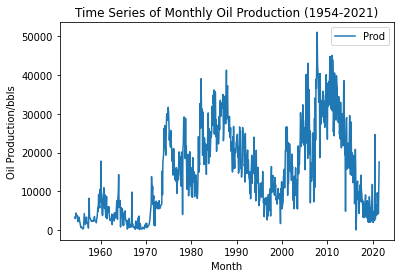

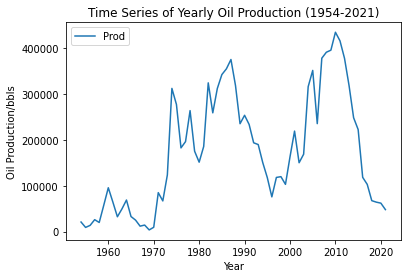

In [7]:
for i in range(2):
    time_vs_var_plot(df_l[i], name_l[i])

### Check for Stationarity: Augmented Dickey-Fuller Test
* $H_0 =$ time series is non-stationary
* $H_1 =$ time series is stationary

We looked at the monthly sum of oil production and conducted a Augmented Dicky-Fuller Test on this dataset.

Although only by a small margin, the Test Statistic is larger than the Critical Value at $\alpha = 0.05$, we fail to reject the null hypothesis, and conclude that the time series is non-stationary.

A series being non-stationary means that there might exist trend, or seasonality, or both. Our next step is to find out whether there are trend and/or seasonality by decomposing the seires.

In [8]:
def adf_test(timeseries, name):
    print('Dickey-Fuller Test Results for ' + name)
    dftest = adfuller(timeseries['Prod'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput[0:7])

In [9]:
adf_test(month_prod, 'Monthly Production')

Dickey-Fuller Test Results for Monthly Production
Test Statistic                  -2.851480
p-value                          0.051288
#Lags Used                       4.000000
Number of Observations Used    760.000000
Critical Value (1%)             -3.438984
Critical Value (5%)             -2.865350
Critical Value (10%)            -2.568799
dtype: float64


### Decomposition

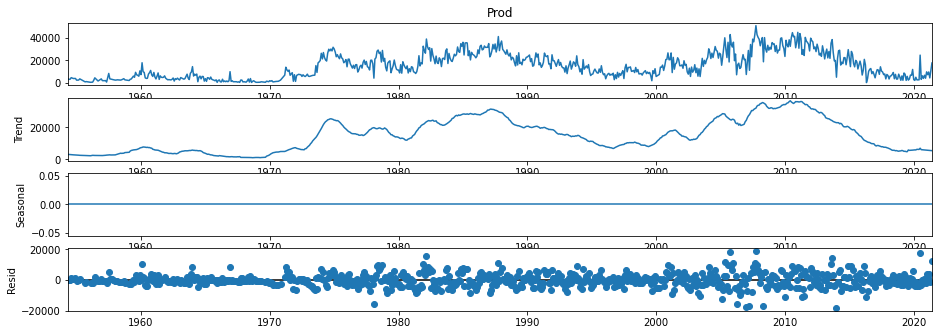

In [10]:
decomposition = seasonal_decompose(month_prod['Prod'], model='additive',extrapolate_trend=1,filt=np.ones(20)/20,two_sided = True, period = 1)
decomp_trend = decomposition.trend; decomp_seasonal = decomposition.seasonal; decomp_residual = decomposition.resid
fig = decomposition.plot()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

### Autocorrelation
- For construction for a predictive model, we must establish the precense of autocorrelation between residual values.
    - Autocorrelation plot:\
    It describes how well the present value of the series is related with its past values.
    - Partial autocorrelation plot:\
    Instead of finding correlations of present with lags like ACF, it finds correlation of the residuals
- Plots also assist us with finding the proper parameters for p and q
    - For the AR process:\
    We expect that the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after `p significant lags`. 
    - For the MA process:\
    We expect that the ACF should show a sharp drop after a certain `q number of lags` while PACF should show a geometric or gradual decreasing trend. 
    - For the ARMA process:\
    If both ACF and PACF plots demonstrate a gradual decreasing pattern, then the ARMA process should be considered for modeling.

### Find Parameters
- We use recursion `differencing` to find the result dataframe through differencing
    - Parameters:
        - *timeseries* (df): input dataframe
        - *n* (int): order of differencing
- We define the funciton `get_diff_stationarity` to plot and run the ADF Test
    - Parameters: 
        - *timeseries* (df): input dataframe
        - *log* (boolean):
            - *True* for conduct log transformation
            - *False* for not conduct log transformation
        - *dif* (int): order of differencing
- We define the function `pacf_n_acf_plots` to plot PACF and ACF plots.


In [18]:
def differencing(timeseries, n):
    if n == 0:
        return timeseries
    if n == 1:
        timeseries_new = timeseries.diff()
        timeseries_new = timeseries_new.fillna(timeseries)
        return timeseries_new
    else:
        old = differencing(timeseries, n - 1)
        new = old.diff()
        new = new.fillna(old)
        return new

In [19]:
def get_diff_stationarity(timeseries, log = False, dif = 0):
    if log:
        timeseries = np.log(timeseries)
    timeseries = differencing(timeseries, dif)

    plt.plot(timeseries, color='blue', label='Original')
    plt.legend(loc='best')
    plt.show()
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Prod'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    print()

In [65]:
def pacf_n_acf_plots(timeseries, log = 0, dif = 0):
    if log:
        timeseries = np.log(timeseries)
    timeseries = differencing(timeseries, dif)
    plot_acf(timeseries)
    plt.title('ACF: ' + str(dif) + 'th Differencing')
    plot_pacf(timeseries)
    plt.title('PACF: ' + str(dif) + 'th Differencing')

#### Find the Parameters: d
- We consider to do a log transformation before differencing since the histogram of the production is very right-skewed.
- We decide to use the parameter `d = 1` or `d = 0`
    - From the ADF Test, the p-value is around 0.051, marginally larger than the confidence level of 0.05, so we can consider `d = 0`.
    - The p-value at the level of $10^{-29}$ is very low after one differencing.
    - We don't want over-differencing to happen to avoid removal of variation in the series.


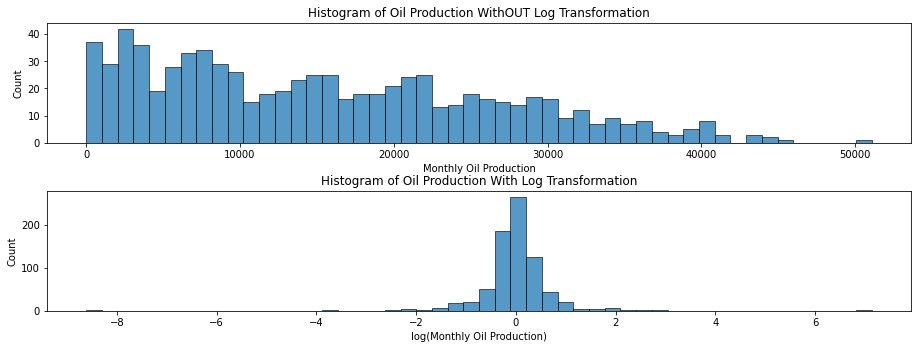

In [20]:
plt.subplot(211)
plt1 = sns.histplot(month_prod.Prod, bins = 50)
plt.title('Histogram of Oil Production WithOUT Log Transformation')
plt.xlabel('Monthly Oil Production')

plt.subplot(212)
plt2 = sns.histplot(np.log(month_prod.Prod).diff(), bins = 50)
plt.title('Histogram of Oil Production With Log Transformation')
plt.xlabel('log(Monthly Oil Production)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.5, hspace=0.4)

0th Differencing With Log Transformation


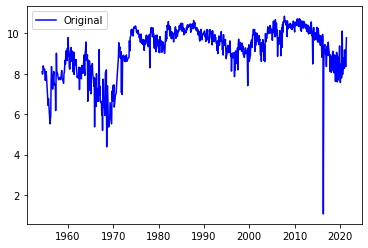

ADF Statistic: -2.499059654850168
p-value: 0.11570328856786821
Critical Values:
	1%: -3.4390179167598367
	5%: -2.8653655786032237
	10%: -2.5688071343462777

1th Differencing With Log Transformation


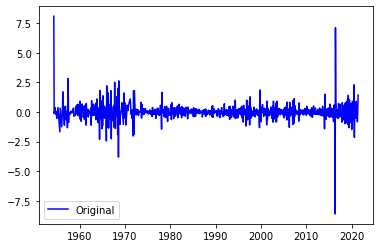

ADF Statistic: -15.988731230514418
p-value: 6.708314343035387e-29
Critical Values:
	1%: -3.439006442437876
	5%: -2.865360521688131
	10%: -2.5688044403756587

2th Differencing With Log Transformation


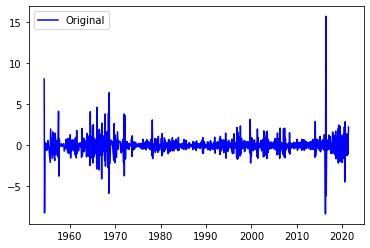

ADF Statistic: -11.435854665536288
p-value: 6.350770993400312e-21
Critical Values:
	1%: -3.4391698996357687
	5%: -2.8654325580580204
	10%: -2.568842816582842



In [21]:
for i in range(3):
    print(str(i) + 'th Differencing With Log Transformation')
    get_diff_stationarity(month_prod, log = True, dif = i)

#### Find the Parameters: p and q
- By the autocorrelation plot
    - Dashed lines: mark the boundaries of the critical range
    - Intercept of the blue line and the dashed line: potential `p` value
- From the intercept, we can find the potential `p` value is `1`.

- By the partial correlation plot
    - Blue area: Blue bars on an ACF plot above are the error bands, and anything within these bars is not statistically significant. It means that correlation values outside of this area are very likely a correlation and not a statistical fluke. The confidence interval is set to 95% by default.
- Since there are 5 points outside of the blue area at the left side of the plot, we think the `q` parameter could be `3 or 4`.
    

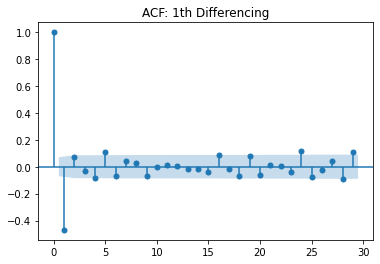

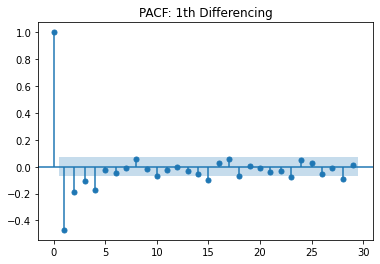

In [32]:
pacf_n_acf_plots(month_prod, dif = 1)

### Try the ARIMA Model
- After trying the orders, we find that the model with parameters (1,1,3) gives the smallest AIC.

In [67]:
orders = [(1,0,3),(1,0,4),(1,1,3),(1,1,4)]
for order in orders:
    try:
        ARIMA_model = ARIMA(month_prod['Prod'], order=order)  
        ARIMA_model_fit = ARIMA_model.fit(transparams = False,disp=-1) 
        print('Order:', order)
        print(ARIMA_model_fit.summary())
        print('*'*100)
    except:
        continue

Order: (1, 0, 3)
                              ARMA Model Results                              
Dep. Variable:                   Prod   No. Observations:                  765
Model:                     ARMA(1, 3)   Log Likelihood               -7556.692
Method:                       css-mle   S.D. of innovations                nan
Date:                Tue, 26 Oct 2021   AIC                          15125.385
Time:                        14:32:45   BIC                          15153.224
Sample:                             0   HQIC                         15136.102
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.553e+04   3770.531      4.118      0.000    8136.710    2.29e+04
ar.L1.Prod     0.9835      0.007    140.904      0.000       0.970       0.997
ma.L1.Prod    -0.6041      0.037   

#### Predict with Training and Testing Sets
- From the plot, we can see that our model's forecast is able to predict the next 5 years about right.

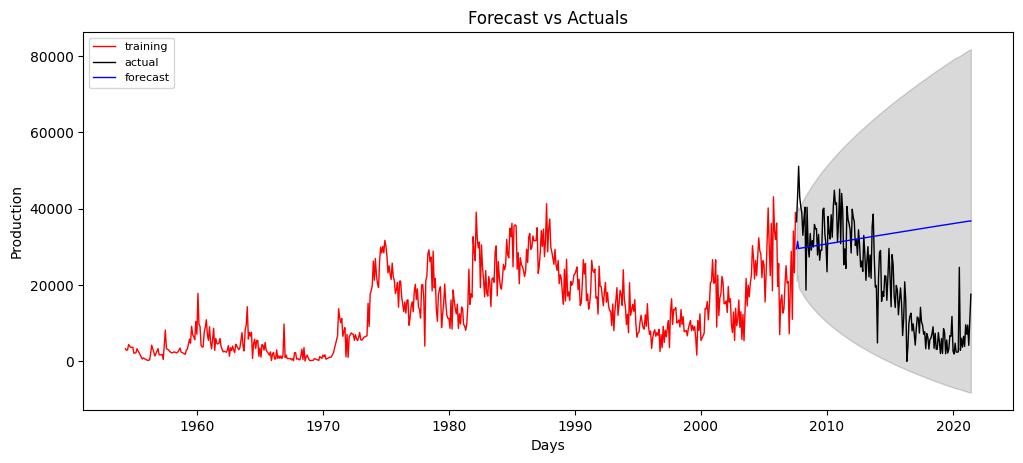

In [69]:
train = month_prod.iloc[:600,0]
test = month_prod.iloc[600:,0]

# the following code taken from https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
# Fit the model to training data
model = ARIMA(train, order=(1, 1, 3))  
fitted = model.fit(disp=-1)  

# Forecast with fit model
fc, se, conf = fitted.forecast(165, alpha=0.05)  # 95% conf

# Convert estimate and confidence interval to Pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot the training, testing and forecast with confidence intervals
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training', color = 'red',linewidth = 1)
plt.plot(test, label='actual', color = 'black',linewidth = 1)
plt.plot(fc_series, label='forecast', color = 'blue',linewidth = 1)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals'); plt.xlabel('Days'); plt.ylabel('Production')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### One Step Ahead Forecast
- By the plot, we can see our model captured the trend of the original dataset well.

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64084D+00    |proj g|=  8.36842D-04

At iterate    5    f=  9.64084D+00    |proj g|=  1.25233D-04

At iterate   10    f=  9.64084D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   1.776D-07   9.641D+00
  F =   9.6408384299377730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64223D+00    |proj g|=  7.65610D-04

At iterate    5    f=  9.64223D+00    |proj g|=  1.20792D-04

At iterate   10    f=  9.64223D+00    |proj g|=  3.55243D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   3.552D-07   9.642D+00
  F =   9.6422267251746199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.64304D+00    |proj g|=  1.13154D-04

At iterate   10    f=  9.64304D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   3.553D-07   9.643D+00
  F =   9.6430373599342989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64241D+00    |proj g|=  7.99361D-04

At iterate    5    f=  9.64241D+00    |proj g|=  1.05338D-04

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     68      1     0     0   1.421D-06   9.642D+00
  F =   9.6422989182095229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64143D+00    |proj g|=  7.96518D-04

At iterate    5    f=  9.64143D+00    |proj g|=  1.03206D-04

At iterate   10    f=  9.64143D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.64045D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.776D-07   9.640D+00
  F =   9.6404502631650200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64238D+00    |proj g|=  8.29559D-04

At iterate    5    f=  9.64238D+00    |proj g|=  1.26299D-04

At iterate   10    f=  9.64238D+00    |proj g|=  3.55271D-07

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64196D+00    |proj g|=  8.35776D-04

At iterate    5    f=  9.64195D+00    |proj g|=  1.30562D-04

At iterate   10    f=  9.64195D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     20      1     0     0   1.776D-07   9.642D+00
  F =   9.6419528362342106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   35    f=  9.64147D+00    |proj g|=  6.97931D-04

At iterate   40    f=  9.64147D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     61      1     0     0   5.329D-07   9.641D+00
  F =   9.6414718194898157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64099D+00    |proj g|=  8.41638D-04

At iterate    5    f=  9.64099D+00    |proj g|=  1.43707D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.64408D+00    |proj g|=  2.28617D-04

At iterate   10    f=  9.64408D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     19      1     0     0   0.000D+00   9.644D+00
  F =   9.6440840723458301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64426D+00    |proj g|=  8.02913D-04

At iterate    5    f=  9.64425D+00    |proj g|=  2.12985D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64725D+00    |proj g|=  7.44649D-04

At iterate    5    f=  9.64725D+00    |proj g|=  1.44951D-04

At iterate   10    f=  9.64725D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.647D+00
  F =   9.6472494225555856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.64556D+00    |proj g|=  1.43707D-04

At iterate   10    f=  9.64556D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   1.776D-07   9.646D+00
  F =   9.6455584939139367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64742D+00    |proj g|=  7.31859D-04

At iterate    5    f=  9.64742D+00    |proj g|=  1.04983D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.66141D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   1.776D-07   9.661D+00
  F =   9.6614100863683792     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66047D+00    |proj g|=  8.65796D-04

At iterate    5    f=  9.66047D+00    |proj g|=  2.05524D-04

At iterate   10    f=  9.66047D+00    |proj g|=  3.55271D-07

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.65981D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   3.553D-07   9.660D+00
  F =   9.6598129580163867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66072D+00    |proj g|=  8.50520D-04

At iterate    5    f=  9.66072D+00    |proj g|=  1.80478D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f=  9.65987D+00    |proj g|=  3.55243D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     35      2     0     0   0.000D+00   9.660D+00
  F =   9.6598749724114548     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66066D+00    |proj g|=  8.82849D-04

At iterate    5    f=  9.66066D+00    |proj g|=  2.04459D-04

At iterate   10    f=  9.66066D+00    |proj g|=  3.55271D-07

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.65887D+00    |proj g|=  1.94511D-04

At iterate   10    f=  9.65887D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   1.776D-07   9.659D+00
  F =   9.6588677975709807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65942D+00    |proj g|=  9.03810D-04

At iterate    5    f=  9.65941D+00    |proj g|=  1.86517D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.65853D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   3.553D-07   9.659D+00
  F =   9.6585304218292407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65762D+00    |proj g|=  9.15179D-04

At iterate    5    f=  9.65761D+00    |proj g|=  1.84741D-04

At iterate   10    f=  9.65761D+00    |proj g|=  1.77636D-07

       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   7.105D-07   9.659D+00
  F =   9.6593498372843438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66052D+00    |proj g|=  9.08074D-04

At iterate    5    f=  9.66052D+00    |proj g|=  2.05880D-04

At iterate   10    f=  9.66052D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.66152D+00    |proj g|=  5.32907D-07

At iterate   15    f=  9.66152D+00    |proj g|=  1.77636D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     24      1     0     0   7.105D-07   9.662D+00
  F =   9.6615228803719617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66071D+00    |proj g|=  9.10383D-04

At iterate    5    f=  9.66070D+00    |proj g|=  2.23288D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65979D+00    |proj g|=  9.09317D-04

At iterate    5    f=  9.65979D+00    |proj g|=  2.08900D-04

At iterate   10    f=  9.65979D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.660D+00
  F =   9.6597870863010957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66096D+00    |proj g|=  9.17666D-04

At iterate    5    f=  9.66096D+00    |proj g|=  1.79234D-04

At iterate   10    f=  9.66096D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   1.776D-07   9.661D+00
  F =   9.6609563973272081     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66118D+00    |proj g|=  9.06297D-04

At iterate    5    f=  9.66118D+00    |proj g|=  2.28617D-04

At iterate   10    f=  9.66118D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   3.553D-07   9.661D+00
  F =   9.6611798237438435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66114D+00    |proj g|=  8.97593D-04

At iterate    5    f=  9.66113D+00    |proj g|=  2.46025D-04

At iterate   10    f=  9.66113D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   3.553D-07   9.661D+00
  F =   9.6611339859594061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66895D+00    |proj g|=  9.22640D-04

At iterate    5    f=  9.66894D+00    |proj g|=  2.18847D-04

At iterate   10    f=  9.66894D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     30      1     0     0   1.776D-07   9.669D+00
  F =   9.6689425992321443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66807D+00    |proj g|=  9.21929D-04

At iterate    5    f=  9.66807D+00    |proj g|=  2.71960D-04

At iterate   10    f=  9.66807D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   0.000D+00   9.668D+00
  F =   9.6680694883268981     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66700D+00    |proj g|=  9.09850D-04

At iterate    5    f=  9.66699D+00    |proj g|=  2.75335D-04

At iterate   10    f=  9.66699D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   3.553D-07   9.667D+00
  F =   9.6669920831070808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12



 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67252D+00    |proj g|=  8.01137D-04

At iterate    5    f=  9.67251D+00    |proj g|=  2.08189D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   0.000D+00   9.673D+00
  F =   9.6725131902495001     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.67255D+00    |proj g|=  2.59348D-04

At iterate   10    f=  9.67255D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   0.000D+00   9.673D+00
  F =   9.6725492495983580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67221D+00    |proj g|=  8.18901D-04

At iterate    5    f=  9.67221D+00    |proj g|=  2.20091D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  9.67139D+00    |proj g|=  2.08544D-04

At iterate   10    f=  9.67139D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     24      1     0     0   1.776D-07   9.671D+00
  F =   9.6713886418479618     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67115D+00    |proj g|=  8.16236D-04

At iterate    5    f=  9.67115D+00    |proj g|=  2.21689D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67393D+00    |proj g|=  7.33280D-04

At iterate    5    f=  9.67393D+00    |proj g|=  1.65379D-04

At iterate   10    f=  9.67393D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   3.553D-07   9.674D+00
  F =   9.6739290901981718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67222D+00    |proj g|=  7.55662D-04

At iterate    5    f=  9.67222D+00    |proj g|=  1.58984D-04

At iterate   10    f=  9.67222D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.776D-07   9.672D+00
  F =   9.6722203284795132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67251D+00    |proj g|=  8.24230D-04

At iterate    5    f=  9.67251D+00    |proj g|=  1.71596D-04

At iterate   10    f=  9.67251D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     20      1     0     0   1.776D-07   9.673D+00
  F =   9.6725088437254030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67662D+00    |proj g|=  9.07896D-04

At iterate    5    f=  9.67662D+00    |proj g|=  4.86189D-04

At iterate   10    f=  9.67662D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.776D-07   9.677D+00
  F =   9.6766184361648371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68199D+00    |proj g|=  8.30802D-04

At iterate    5    f=  9.68198D+00    |proj g|=  2.49756D-04

At iterate   10    f=  9.68198D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.776D-07   9.682D+00
  F =   9.6819824236159562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69236D+00    |proj g|=  7.17826D-04

At iterate    5    f=  9.69236D+00    |proj g|=  1.41931D-04

At iterate   10    f=  9.69236D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   1.776D-07   9.692D+00
  F =   9.6923604976694513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70146D+00    |proj g|=  7.26530D-04

At iterate    5    f=  9.70146D+00    |proj g|=  1.25233D-04

At iterate   10    f=  9.70146D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     18      1     0     0   1.776D-07   9.701D+00
  F =   9.7014615845373999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72068D+00    |proj g|=  6.90115D-04

At iterate    5    f=  9.72067D+00    |proj g|=  1.20970D-04

At iterate   10    f=  9.72067D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   3.553D-07   9.721D+00
  F =   9.7206746622306603     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72014D+00    |proj g|=  7.08589D-04

At iterate    5    f=  9.72014D+00    |proj g|=  1.45839D-04

At iterate   10    f=  9.72014D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     21      1     0     0   3.553D-07   9.720D+00
  F =   9.7201381314956574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72815D+00    |proj g|=  8.58513D-04

At iterate    5    f=  9.72815D+00    |proj g|=  1.65912D-04

At iterate   10    f=  9.72815D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     19      1     0     0   3.553D-07   9.728D+00
  F =   9.7281457701083855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74213D+00    |proj g|=  1.00027D-03

At iterate    5    f=  9.74213D+00    |proj g|=  3.19034D-04

At iterate   10    f=  9.74212D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.742D+00
  F =   9.7421248289906988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74104D+00    |proj g|=  1.00524D-03

At iterate    5    f=  9.74103D+00    |proj g|=  3.71791D-04

At iterate   10    f=  9.74103D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   3.553D-07   9.741D+00
  F =   9.7410306631570318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74103D+00    |proj g|=  1.00044D-03

At iterate    5    f=  9.74102D+00    |proj g|=  3.20632D-04

At iterate   10    f=  9.74102D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     25      1     0     0   3.553D-07   9.741D+00
  F =   9.7410221839772717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74464D+00    |proj g|=  9.86589D-04

At iterate    5    f=  9.74464D+00    |proj g|=  3.45146D-04

At iterate   10    f=  9.74464D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.776D-07   9.745D+00
  F =   9.7446363763423296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74300D+00    |proj g|=  1.00435D-03

At iterate    5    f=  9.74299D+00    |proj g|=  4.06430D-04

At iterate   10    f=  9.74299D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     21      1     0     0   3.553D-07   9.743D+00
  F =   9.7429898727776649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75011D+00    |proj g|=  1.05036D-03

At iterate    5    f=  9.75011D+00    |proj g|=  3.32001D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   0.000D+00   9.750D+00
  F =   9.7501070849933349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76440D+00    |proj g|=  1.06173D-03

At iterate    5    f=  9.76439D+00    |proj g|=  2.89724D-04

At iterate   10    f=  9.76439D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     16      1     0     0   1.776D-07   9.764D+00
  F =   9.7643878760237488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77309D+00    |proj g|=  9.95293D-04

At iterate    5    f=  9.77308D+00    |proj g|=  3.70370D-04

At iterate   10    f=  9.77308D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     18      1     0     0   1.776D-07   9.773D+00
  F =   9.7730786324544585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78189D+00    |proj g|=  7.78755D-04

At iterate    5    f=  9.78189D+00    |proj g|=  1.47260D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     15      1     0     0   1.776D-07   9.782D+00
  F =   9.7818892041712182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79298D+00    |proj g|=  4.14779D-04

At iterate    5    f=  9.79298D+00    |proj g|=  5.87974D-05

At iterate   10    f=  9.79298D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   0.000D+00   9.793D+00
  F =   9.7929772673421684     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79182D+00    |proj g|=  5.06084D-04

At iterate    5    f=  9.79182D+00    |proj g|=  5.32907D-06

At iterate   10    f=  9.79182D+00    |proj g|=  1.24345D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     18      1     0     0   1.776D-07   9.792D+00
  F =   9.7918150580210881     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79158D+00    |proj g|=  6.35580D-04

At iterate    5    f=  9.79158D+00    |proj g|=  8.79297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   5.329D-07   9.792D+00
  F =   9.7915772524187794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79114D+00    |proj g|=  5.69145D-04

At iterate    5    f=  9.79114D+00    |proj g|=  4.77840D-05

At iterate   10    f=  9.79114D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   3.553D-07   9.791D+00
  F =   9.7911369941449067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80961D+00    |proj g|=  1.43494D-03

At iterate    5    f=  9.80959D+00    |proj g|=  4.36984D-04

At iterate   10    f=  9.80959D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.776D-07   9.810D+00
  F =   9.8095918981818482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80964D+00    |proj g|=  8.10019D-04

At iterate    5    f=  9.80964D+00    |proj g|=  1.22924D-04

At iterate   10    f=  9.80964D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.810D+00
  F =   9.8096373420290952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80857D+00    |proj g|=  8.00959D-04

At iterate    5    f=  9.80857D+00    |proj g|=  1.20437D-04

At iterate   10    f=  9.80857D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   0.000D+00   9.809D+00
  F =   9.8085653323167428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80699D+00    |proj g|=  8.12150D-04

At iterate    5    f=  9.80698D+00    |proj g|=  1.18305D-04

At iterate   10    f=  9.80698D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.776D-07   9.807D+00
  F =   9.8069819217822243     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80722D+00    |proj g|=  1.18412D-03

At iterate    5    f=  9.80720D+00    |proj g|=  4.50484D-04

At iterate   10    f=  9.80720D+00    |proj g|=  7.10543D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     23      1     0     0   7.105D-07   9.807D+00
  F =   9.8072023596231990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80696D+00    |proj g|=  8.11617D-04

At iterate    5    f=  9.80695D+00    |proj g|=  1.28253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   0.000D+00   9.807D+00
  F =   9.8069513402214596     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80616D+00    |proj g|=  8.40217D-04

At iterate    5    f=  9.80615D+00    |proj g|=  1.39444D-04

At iterate   10    f=  9.80615D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   0.000D+00   9.806D+00
  F =   9.8061538754830533     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80460D+00    |proj g|=  8.52474D-04

At iterate    5    f=  9.80460D+00    |proj g|=  1.54898D-04

At iterate   10    f=  9.80460D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   1.776D-07   9.805D+00
  F =   9.8045976203086873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81026D+00    |proj g|=  6.80167D-04

At iterate    5    f=  9.81025D+00    |proj g|=  1.00542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   0.000D+00   9.810D+00
  F =   9.8102529926615638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81027D+00    |proj g|=  8.06466D-04

At iterate    5    f=  9.81027D+00    |proj g|=  1.47793D-04

At iterate   10    f=  9.81027D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.776D-07   9.810D+00
  F =   9.8102707518074883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81550D+00    |proj g|=  8.07887D-04

At iterate    5    f=  9.81550D+00    |proj g|=  1.60227D-04

At iterate   10    f=  9.81550D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     18      1     0     0   1.776D-07   9.815D+00
  F =   9.8154969515897594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81460D+00    |proj g|=  8.17835D-04

At iterate    5    f=  9.81460D+00    |proj g|=  1.75682D-04

At iterate   10    f=  9.81460D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     17      1     0     0   1.776D-07   9.815D+00
  F =   9.8145952590962739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81449D+00    |proj g|=  7.83551D-04

At iterate    5    f=  9.81448D+00    |proj g|=  1.49392D-04

At iterate   10    f=  9.81448D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   3.553D-07   9.814D+00
  F =   9.8144844993131990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81799D+00    |proj g|=  6.03961D-04

At iterate    5    f=  9.81799D+00    |proj g|=  8.20677D-05

At iterate   10    f=  9.81799D+00    |proj g|=  7.10543D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     16      1     0     0   7.105D-07   9.818D+00
  F =   9.8179871777413901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81647D+00    |proj g|=  6.02718D-04

At iterate    5    f=  9.81647D+00    |proj g|=  8.31335D-05

At iterate   10    f=  9.81647D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   1.776D-07   9.816D+00
  F =   9.8164664074633361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81783D+00    |proj g|=  1.38023D-03

At iterate    5    f=  9.81781D+00    |proj g|=  7.91722D-04

At iterate   10    f=  9.81780D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.776D-07   9.818D+00
  F =   9.8178035356502651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82366D+00    |proj g|=  7.26708D-04

At iterate    5    f=  9.82366D+00    |proj g|=  1.28964D-04

At iterate   10    f=  9.82366D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.776D-07   9.824D+00
  F =   9.8236584220976031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82395D+00    |proj g|=  6.30429D-04

At iterate    5    f=  9.82395D+00    |proj g|=  1.16884D-04

At iterate   10    f=  9.82395D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   3.553D-07   9.824D+00
  F =   9.8239460582871914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83098D+00    |proj g|=  8.56382D-04

At iterate    5    f=  9.83097D+00    |proj g|=  2.65388D-04

At iterate   10    f=  9.83097D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   3.553D-07   9.831D+00
  F =   9.8309730874252708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83617D+00    |proj g|=  8.05223D-04

At iterate    5    f=  9.83616D+00    |proj g|=  1.95932D-04

At iterate   10    f=  9.83616D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.836D+00
  F =   9.8361642394995528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83552D+00    |proj g|=  7.80531D-04

At iterate    5    f=  9.83552D+00    |proj g|=  1.67866D-04

At iterate   10    f=  9.83552D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.776D-07   9.836D+00
  F =   9.8355203577051871     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83514D+00    |proj g|=  8.64020D-04

At iterate    5    f=  9.83513D+00    |proj g|=  2.90967D-04

At iterate   10    f=  9.83513D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     21      1     0     0   1.776D-07   9.835D+00
  F =   9.8351334321191040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83686D+00    |proj g|=  7.51577D-04

At iterate    5    f=  9.83686D+00    |proj g|=  1.68754D-04

At iterate   10    f=  9.83686D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.776D-07   9.837D+00
  F =   9.8368590651396772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83659D+00    |proj g|=  8.40394D-04

At iterate    5    f=  9.83659D+00    |proj g|=  2.54374D-04

At iterate   10    f=  9.83659D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   1.776D-07   9.837D+00
  F =   9.8365850321343515     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83558D+00    |proj g|=  8.97593D-04

At iterate    5    f=  9.83557D+00    |proj g|=  3.20277D-04

At iterate   10    f=  9.83557D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.836D+00
  F =   9.8355720438112471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83468D+00    |proj g|=  8.84448D-04

At iterate    5    f=  9.83467D+00    |proj g|=  3.16014D-04

At iterate   10    f=  9.83467D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.776D-07   9.835D+00
  F =   9.8346743097229012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83528D+00    |proj g|=  9.65805D-04

At iterate    5    f=  9.83528D+00    |proj g|=  3.74811D-04

At iterate   10    f=  9.83528D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   3.553D-07   9.835D+00
  F =   9.8352766793763884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83600D+00    |proj g|=  9.51239D-04

At iterate    5    f=  9.83599D+00    |proj g|=  3.75167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     14      1     0     0   1.776D-07   9.836D+00
  F =   9.8359925297370960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83702D+00    |proj g|=  1.01217D-03

At iterate    5    f=  9.83701D+00    |proj g|=  3.51008D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   0.000D+00   9.837D+00
  F =   9.8370138574332557     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83690D+00    |proj g|=  9.84279D-04

At iterate    5    f=  9.83689D+00    |proj g|=  3.82983D-04

At iterate   10    f=  9.83689D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   1.776D-07   9.837D+00
  F =   9.8368944130098370     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83657D+00    |proj g|=  1.01661D-03

At iterate    5    f=  9.83656D+00    |proj g|=  3.59357D-04

At iterate   10    f=  9.83656D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.837D+00
  F =   9.8365624828288016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83968D+00    |proj g|=  9.85523D-04

At iterate    5    f=  9.83967D+00    |proj g|=  4.17799D-04

At iterate   10    f=  9.83967D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   3.553D-07   9.840D+00
  F =   9.8396716128252013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84406D+00    |proj g|=  9.71845D-04

At iterate    5    f=  9.84405D+00    |proj g|=  4.35740D-04

At iterate   10    f=  9.84405D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.844D+00
  F =   9.8440527234175690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84805D+00    |proj g|=  1.08002D-03

At iterate    5    f=  9.84804D+00    |proj g|=  3.60068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   1.776D-07   9.848D+00
  F =   9.8480423757227733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85727D+00    |proj g|=  1.10632D-03

At iterate    5    f=  9.85726D+00    |proj g|=  3.33245D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.776D-07   9.857D+00
  F =   9.8572583602519970     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86174D+00    |proj g|=  1.08464D-03

At iterate    5    f=  9.86173D+00    |proj g|=  3.23475D-04

At iterate   10    f=  9.86173D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   3.553D-07   9.862D+00
  F =   9.8617293626033806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86494D+00    |proj g|=  1.14184D-03

At iterate    5    f=  9.86493D+00    |proj g|=  3.30225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   1.776D-07   9.865D+00
  F =   9.8649270147678809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86397D+00    |proj g|=  1.14415D-03

At iterate    5    f=  9.86395D+00    |proj g|=  3.37863D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.553D-07   9.864D+00
  F =   9.8639537862545712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86374D+00    |proj g|=  1.15712D-03

At iterate    5    f=  9.86373D+00    |proj g|=  3.39107D-04

At iterate   10    f=  9.86373D+00    |proj g|=  1.77621D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.864D+00
  F =   9.8637274199719656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86619D+00    |proj g|=  1.12550D-03

At iterate    5    f=  9.86618D+00    |proj g|=  3.33600D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.776D-07   9.866D+00
  F =   9.8661776697067420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86828D+00    |proj g|=  1.17151D-03

At iterate    5    f=  9.86827D+00    |proj g|=  3.24896D-04

At iterate   10    f=  9.86827D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.776D-07   9.868D+00
  F =   9.8682700103087928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87022D+00    |proj g|=  1.13687D-03

At iterate    5    f=  9.87020D+00    |proj g|=  3.19922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   1.776D-07   9.870D+00
  F =   9.8702025859873430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87254D+00    |proj g|=  1.17826D-03

At iterate    5    f=  9.87252D+00    |proj g|=  3.71081D-04

At iterate   10    f=  9.87252D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     17      1     0     0   5.329D-07   9.873D+00
  F =   9.8725219102955428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87137D+00    |proj g|=  1.17950D-03

At iterate    5    f=  9.87136D+00    |proj g|=  4.07141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   0.000D+00   9.871D+00
  F =   9.8713599442426112     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87167D+00    |proj g|=  1.17755D-03

At iterate    5    f=  9.87166D+00    |proj g|=  4.52971D-04

At iterate   10    f=  9.87166D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   3.553D-07   9.872D+00
  F =   9.8716564845624468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87093D+00    |proj g|=  1.18074D-03

At iterate    5    f=  9.87092D+00    |proj g|=  4.91340D-04

At iterate   10    f=  9.87091D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     17      1     0     0   1.776D-07   9.871D+00
  F =   9.8709148621715279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87297D+00    |proj g|=  1.15641D-03

At iterate    5    f=  9.87296D+00    |proj g|=  5.01288D-04

At iterate   10    f=  9.87296D+00    |proj g|=  3.55243D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   5.329D-07   9.873D+00
  F =   9.8729603081411934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87450D+00    |proj g|=  1.17968D-03

At iterate    5    f=  9.87449D+00    |proj g|=  5.21894D-04

At iterate   10    f=  9.87449D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   1.776D-07   9.874D+00
  F =   9.8744908143883805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88318D+00    |proj g|=  1.10045D-03

At iterate    5    f=  9.88317D+00    |proj g|=  4.82281D-04

At iterate   10    f=  9.88317D+00    |proj g|=  1.77636D-07

At iterate   15    f=  9.88317D+00    |proj g|=  1.77636D-07

At iterate   20    f=  9.88317D+00    |proj g|=  2.13163D-06
  ys=-7.578E-11  -gs= 3.516E-10 BFGS update SKIPPED

At iterate   25    f=  9.88317D+00    |proj g|=  1.42109D-06

At iterate   30    f=  9.88317D+00    |proj g|=  1.26121D-05

At iterate   35    f=  9.88317D+00    |proj g|=  3.49942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88199D+00    |proj g|=  1.14184D-03

At iterate    5    f=  9.88198D+00    |proj g|=  5.03242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   0.000D+00   9.882D+00
  F =   9.8819829878100656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88098D+00    |proj g|=  1.12585D-03

At iterate    5    f=  9.88097D+00    |proj g|=  4.81570D-04

At iterate   10    f=  9.88097D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   1.776D-07   9.881D+00
  F =   9.8809729293928328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88049D+00    |proj g|=  1.08820D-03

At iterate    5    f=  9.88048D+00    |proj g|=  4.59899D-04

At iterate   10    f=  9.88048D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   1.776D-07   9.880D+00
  F =   9.8804816502538895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87862D+00    |proj g|=  1.09903D-03

At iterate    5    f=  9.87861D+00    |proj g|=  4.53149D-04

At iterate   10    f=  9.87861D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   3.553D-07   9.879D+00
  F =   9.8786085377342978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87798D+00    |proj g|=  1.11093D-03

At iterate    5    f=  9.87797D+00    |proj g|=  4.77129D-04

At iterate   10    f=  9.87797D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.776D-07   9.878D+00
  F =   9.8779736716241064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87655D+00    |proj g|=  1.05622D-03

At iterate    5    f=  9.87654D+00    |proj g|=  4.42846D-04

At iterate   10    f=  9.87654D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     17      1     0     0   1.776D-07   9.877D+00
  F =   9.8765425313087256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87518D+00    |proj g|=  1.05072D-03

At iterate    5    f=  9.87518D+00    |proj g|=  4.44444D-04

At iterate   10    f=  9.87517D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   3.553D-07   9.875D+00
  F =   9.8751744854801906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87431D+00    |proj g|=  1.02141D-03

At iterate    5    f=  9.87430D+00    |proj g|=  4.29345D-04

At iterate   10    f=  9.87430D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   8.882D-07   9.874D+00
  F =   9.8743033606420827     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     33      2     0     0   1.776D-07   9.874D+00
  F =   9.8736199457073415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87297D+00    |proj g|=  1.02336D-03

At iterate    5    f=  9.87296D+00    |proj g|=  4.28102D-04

At iterate   10    f=  9.87296D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87172D+00    |proj g|=  1.01057D-03

At iterate    5    f=  9.87171D+00    |proj g|=  4.13181D-04

At iterate   10    f=  9.87171D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   5.329D-07   9.872D+00
  F =   9.8717098131098862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87087D+00    |proj g|=  9.72911D-04

At iterate    5    f=  9.87087D+00    |proj g|=  3.86358D-04

At iterate   10    f=  9.87087D+00    |proj g|=  3.55271D-07

At iterate   15    f=  9.87087D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     21      1     0     0   1.776D-07   9.871D+00
  F =   9.8708655320357455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     25      1     0     0   3.553D-07   9.870D+00
  F =   9.8704619395638034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86981D+00    |proj g|=  9.80194D-04

At iterate    5    f=  9.86980D+00    |proj g|=  3.87779D-04

At iterate   10    f=  9.86980D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86866D+00    |proj g|=  9.38805D-04

At iterate    5    f=  9.86865D+00    |proj g|=  3.60956D-04

At iterate   10    f=  9.86865D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   0.000D+00   9.869D+00
  F =   9.8686512044096819     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86790D+00    |proj g|=  9.64739D-04

At iterate    5    f=  9.86789D+00    |proj g|=  3.68239D-04

At iterate   10    f=  9.86789D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   3.553D-07   9.868D+00
  F =   9.8678895773506365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86696D+00    |proj g|=  9.17844D-04

At iterate    5    f=  9.86696D+00    |proj g|=  3.39107D-04

At iterate   10    f=  9.86696D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     17      1     0     0   3.553D-07   9.867D+00
  F =   9.8669553378888839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86553D+00    |proj g|=  9.45199D-04

At iterate    5    f=  9.86552D+00    |proj g|=  3.46567D-04

At iterate   10    f=  9.86552D+00    |proj g|=  1.77636D-07

At iterate   15    f=  9.86552D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   3.553D-07   9.866D+00
  F =   9.8655193755576409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86471D+00    |proj g|=  8.80362D-04

At iterate    5    f=  9.86471D+00    |proj g|=  3.04290D-04

At iterate   10    f=  9.86471D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   1.776D-07   9.865D+00
  F =   9.8647081349497761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87692D+00    |proj g|=  9.49285D-04

At iterate    5    f=  9.87691D+00    |proj g|=  3.04645D-04

At iterate   10    f=  9.87691D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   0.000D+00   9.877D+00
  F =   9.8769134461671690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87747D+00    |proj g|=  9.03455D-04

At iterate    5    f=  9.87746D+00    |proj g|=  2.84750D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   0.000D+00   9.877D+00
  F =   9.8774614052067591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87675D+00    |proj g|=  9.03633D-04

At iterate    5    f=  9.87674D+00    |proj g|=  2.90967D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.776D-07   9.877D+00
  F =   9.8767407169821499     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87552D+00    |proj g|=  9.05942D-04

At iterate    5    f=  9.87551D+00    |proj g|=  2.89724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.553D-07   9.876D+00
  F =   9.8755110299569075     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


Test RMSE: 6247.509


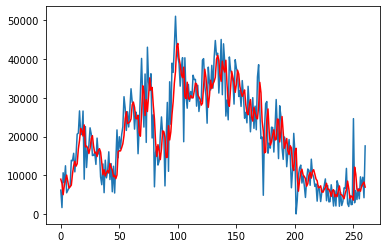

In [71]:
series = month_prod
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(sk.mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

#### Compare RMSE with a Dummies RMSE
- Dummy RMSE:
    - We set a dataframe where the response is f(t + 1) and the predictor is f(t), where t is time, and f(t) denotes the oil production during the one month period for month t.
    - The dummy RMSE is calculated by: taking the square root of the average of the difference between values within one time unit.
- Our model yields a RMSE of 6247.5089, 1000 less than the RMSE yielded by the dummy dataframe.

In [72]:
fit_rmse = math.sqrt((sk.mean_squared_error(test, predictions)))
dummy_rmse = math.sqrt(np.mean((month_prod.iloc[size+1:].values - month_prod.iloc[size:-1].values)**2))
print('RMSE for ARIMA model:', fit_rmse)
print('Dummy RMSE:', dummy_rmse)

RMSE for ARIMA model: 6247.508891666147
Dummy RMSE: 7438.621664982856
